### Predicting Outstanding Loan Balance at any given Observation Time

This project aims to analyze borrower behavior and loan performance using financial datasets to develop a predictive model. The dataset includes a variety of borrower, loan, and macroeconomic factors, such as loan-to-value ratios, interest rates, house price indices, and credit scores, which influence loan repayment dynamics over time. The primary goal is to use regression to predict the outstanding loan balance at any given observation time. By identifying the key factors that affect the loan balance, this model could help financial institutions better understand loan risk profiles and enhance their decision-making regarding borrower management and loan performance assessment.

In [38]:
#Libraries
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import warnings

In [39]:
df = pd.read_csv('mortgage.csv')
df.head()

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
0,1,25,-7,25,113,41303.42,24.498336,9.2,226.29,2.899137,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
1,1,26,-7,25,113,41061.95,24.483867,9.2,225.10,2.151365,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
2,1,27,-7,25,113,40804.42,24.626795,9.2,222.39,2.361722,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
3,1,28,-7,25,113,40483.89,24.735883,9.2,219.67,1.229172,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
4,1,29,-7,25,113,40367.06,24.925476,9.2,217.37,1.692969,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0


#### Preparing and Feature Engineering

The data set mortgage is in panel form and reports origination and performance observations for 50,000 residential U.S. mortgage borrowers over 60 periods. The periods have been identified. As in the real world, loans may originate before the start of the observation period 
(this is an issue where loans are transferred between banks and investors as in securitization).

In [40]:
# Checking if any rows violate the logical progression of time
df['time_check'] = (df['first_time'] > df['time']) | \
                   (df['orig_time'] > df['time']) | \
                   (df['time'] > df['mat_time'])

# Display rows with problematic time sequences
problematic_rows = df[df['time_check']]
print(problematic_rows)

if problematic_rows.empty:
    print("All time variables follow a logical progression.")
else:
    print(f"There are {len(problematic_rows)} rows with time progression issues.")


Empty DataFrame
Columns: [id, time, orig_time, first_time, mat_time, balance_time, LTV_time, interest_rate_time, hpi_time, gdp_time, uer_time, REtype_CO_orig_time, REtype_PU_orig_time, REtype_SF_orig_time, investor_orig_time, balance_orig_time, FICO_orig_time, LTV_orig_time, Interest_Rate_orig_time, hpi_orig_time, default_time, payoff_time, status_time, time_check]
Index: []

[0 rows x 24 columns]
All time variables follow a logical progression.


In [41]:
# Flag any unrealistic values
df['unrealistic_balance_flag'] = df['balance_time'].apply(lambda x: 1 if x < 0 else 0)
df['unrealistic_LTV_flag'] = df['LTV_time'].apply(lambda x: 1 if x < 0 else 0)
df['unrealistic_interest_rate_flag'] = df['interest_rate_time'].apply(lambda x: 1 if x < 0 or x > 40 else 0)

# Check how many rows have unrealistic values
unrealistic_rows = df[(df['unrealistic_balance_flag'] == 1) | 
                      (df['unrealistic_LTV_flag'] == 1) | 
                      (df['unrealistic_interest_rate_flag'] == 1)]

print(f"{len(unrealistic_rows)} rows have unrealistic values.")

0 rows have unrealistic values.


#### Outlier detection

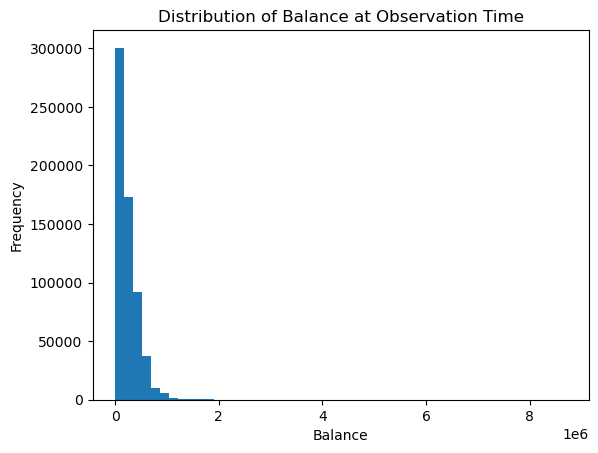

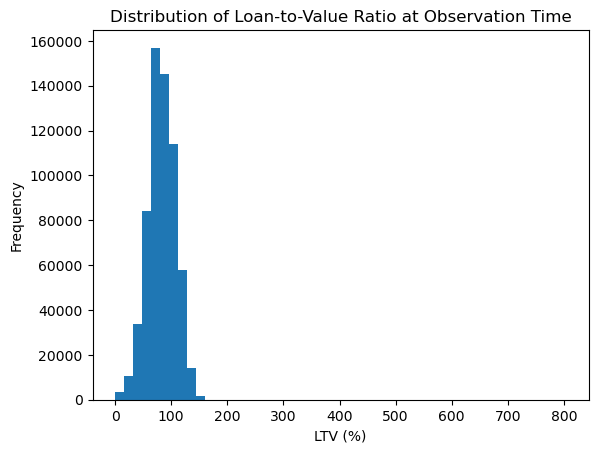

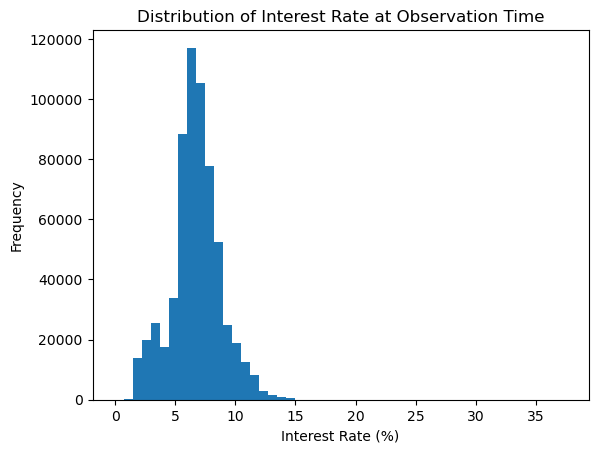

In [42]:
# Plot distribution for balance_time
plt.hist(df['balance_time'], bins=50)
plt.title('Distribution of Balance at Observation Time')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.show()

# Plot distribution for LTV_time
plt.hist(df['LTV_time'], bins=50)
plt.title('Distribution of Loan-to-Value Ratio at Observation Time')
plt.xlabel('LTV (%)')
plt.ylabel('Frequency')
plt.show()

# Plot distribution for interest_rate_time
plt.hist(df['interest_rate_time'], bins=50)
plt.title('Distribution of Interest Rate at Observation Time')
plt.xlabel('Interest Rate (%)')
plt.ylabel('Frequency')
plt.show()



In [43]:
#Standardizing the predictors to aid optimization by the gradient descent algorithm

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

columns_to_standardize = ['balance_time', 'LTV_time', 'interest_rate_time', 
                          'hpi_time', 'gdp_time', 'uer_time']

df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

In [44]:
df.head()

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time,time_check,unrealistic_balance_flag,unrealistic_LTV_flag,unrealistic_interest_rate_flag
0,1,25,-7,25,113,-0.955665,-2.346122,1.201182,1.525729,0.772713,...,69.4,9.2,87.03,0,0,0,False,0,0,0
1,1,26,-7,25,113,-0.956792,-2.346702,1.201182,1.482692,0.392098,...,69.4,9.2,87.03,0,0,0,False,0,0,0
2,1,27,-7,25,113,-0.957995,-2.340978,1.201182,1.384684,0.499170,...,69.4,9.2,87.03,0,0,0,False,0,0,0
3,1,28,-7,25,113,-0.959491,-2.336609,1.201182,1.286314,-0.077296,...,69.4,9.2,87.03,0,0,0,False,0,0,0
4,1,29,-7,25,113,-0.960037,-2.329015,1.201182,1.203134,0.158775,...,69.4,9.2,87.03,0,0,0,False,0,0,0


#### Preparing predictors

In [45]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


data = df[['time', 'orig_time', 'mat_time', 'balance_time', 'LTV_time',
            'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time',
            'FICO_orig_time', 'status_time', 'balance_orig_time',
            'REtype_SF_orig_time']]

data['loan_age'] = data['time'] - data['orig_time'] #How long the loan has been active.

data['time_to_maturity'] = data['mat_time'] - data['time'] #How much time is left until the loan matures.

data['time_LTV_int'] = data['time'] * data['LTV_time'] # Interaction because LTV is dependent property value which has significant interaction with time




#### Predictors and Target Variable

In [46]:
X = data[['loan_age', 'time_to_maturity', 'LTV_time', 
          'time_LTV_int', 'interest_rate_time', 'hpi_time', 'gdp_time',
          'uer_time', 'FICO_orig_time', 'status_time','balance_orig_time',
          'REtype_SF_orig_time']]

y = data['balance_time']

X.isna().sum()

loan_age                 0
time_to_maturity         0
LTV_time               270
time_LTV_int           270
interest_rate_time       0
hpi_time                 0
gdp_time                 0
uer_time                 0
FICO_orig_time           0
status_time              0
balance_orig_time        0
REtype_SF_orig_time      0
dtype: int64

In [47]:
#Using KNN to deal with the missing LTV values
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

X[['LTV_time']] = imputer.fit_transform(X[['LTV_time']])
X[['time_LTV_int']] = imputer.fit_transform(X[['time_LTV_int']])

X.isna().sum()


loan_age               0
time_to_maturity       0
LTV_time               0
time_LTV_int           0
interest_rate_time     0
hpi_time               0
gdp_time               0
uer_time               0
FICO_orig_time         0
status_time            0
balance_orig_time      0
REtype_SF_orig_time    0
dtype: int64

#### Train-Test Split

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [51]:
import numpy as np
import statsmodels.api as sm

# Add a constant term for the intercept
X_train_sm = sm.add_constant(X_train)

# Fit the model using statsmodels for detailed summary
model_1 = sm.OLS(y_train, X_train_sm).fit()

model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           balance_time   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 1.788e+06
Date:                Sat, 07 Sep 2024   Prob (F-statistic):               0.00
Time:                        12:00:53   Log-Likelihood:             2.3812e+05
No. Observations:              497991   AIC:                        -4.762e+05
Df Residuals:                  497978   BIC:                        -4.761e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.2739      0.003   -426.381      0.000      -1.280      -1.268
loan_age                0.0002   2.81e-05      8.718      0.000       0.000       0.000
time_to_maturity        0.0013   1.42e-05     92.050      0.000       0.001       0.001
LTV_time               -0.0506      0.001    -58.192      0.000      -0.052      -0.049
time_LTV_int            0.0030   2.16e-05    140.491      0.000       0.003       0.003
interest_rate_time      0.0120      0.000     46.932      0.000       0.011       0.012
hpi_time                0.0239      0.000     60.050      0.000       0.023       0.025
gdp_time               -0.0042      0.000    -16.273      0.000      -0.005      -0.004
uer_time               -0.0124      0.000    -31.329      0.000      -0.013      -0.012
FICO_orig_time      -2.214e-05    3.4e-06     -6.503      0.000   -2.88e-05   -1.55e-05
status_time            -0.0078      0.001    -15.535      0.000      -0.009      -0.007
balance_orig_time    4.471e-06   1.06e-09   4201.655      0.000    4.47e-06    4.47e-06
REtype_SF_orig_time    -0.0037      0.000     -8.376      0.000      -0.005      -0.003
==============================================================================
Omnibus:                   924781.654   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       5497706652.323
Skew:                         -13.499   Prob(JB):                         0.00
Kurtosis:                     517.029   Cond. No.                     4.74e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.74e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Predictions for Model 1:

In [52]:
from sklearn.metrics import mean_squared_error, r2_score
X_test = X_test
X_test = sm.add_constant(X_test)
y_pred = model_1.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.021076428856578084
R^2 Score: 0.9795817750400083


In [53]:
#Aiming for a simpler model by using VIF to check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X_train_sm
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]


print(vif_data)

                feature         VIF
0                 const  197.545441
1              loan_age    2.397020
2      time_to_maturity    1.977239
3              LTV_time   16.645610
4          time_LTV_int   15.871091
5    interest_rate_time    1.449661
6              hpi_time    3.515860
7              gdp_time    1.452042
8              uer_time    3.466706
9        FICO_orig_time    1.320482
10          status_time    1.017545
11    balance_orig_time    1.202189
12  REtype_SF_orig_time    1.022343


From the VIF values it appears Loan-to-value ratio at observation and its interaction with time, House price index at observation time, and Unemployment rate at observation time are highly correlated. This is probably due to   overlapping information time and needs to be taken from the data. 

In [54]:
predictors_to_remove = ['LTV_time', 'time_LTV_int', 
                        'hpi_time', 'uer_time']

X_train_sm = X_train_sm.drop(columns = predictors_to_remove)

X_train_sm.head()



,const,loan_age,time_to_maturity,interest_rate_time,gdp_time,FICO_orig_time,status_time,balance_orig_time,REtype_SF_orig_time
162215,1.0,31,87,-1.961026,0.171034,702,0,160000.0,1
124699,1.0,3,118,-0.097367,0.885740,728,2,172800.0,1
316266,1.0,1,116,0.804403,0.499170,624,0,42000.0,1
268492,1.0,6,114,0.383577,0.239055,668,0,101430.0,0
262314,1.0,14,107,-0.518193,-2.131113,794,0,322400.0,0


In [55]:
model_2 = sm.OLS(y_train, X_train_sm).fit()

model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           balance_time   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                 2.343e+06
Date:                Sat, 07 Sep 2024   Prob (F-statistic):               0.00
Time:                        12:01:11   Log-Likelihood:             2.0528e+05
No. Observations:              497991   AIC:                        -4.105e+05
Df Residuals:                  497982   BIC:                        -4.104e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.3376      0.003   -425.182      0.000      -1.344      -1.331
loan_age               -0.0013   2.62e-05    -49.444      0.000      -0.001      -0.001
time_to_maturity        0.0025   1.41e-05    174.213      0.000       0.002       0.002
interest_rate_time      0.0085      0.000     31.654      0.000       0.008       0.009
gdp_time               -0.0041      0.000    -18.050      0.000      -0.005      -0.004
FICO_orig_time      -4.345e-05   3.63e-06    -11.954      0.000   -5.06e-05   -3.63e-05
status_time            -0.0119      0.001    -22.283      0.000      -0.013      -0.011
balance_orig_time    4.455e-06   1.13e-09   3928.715      0.000    4.45e-06    4.46e-06
REtype_SF_orig_time    -0.0056      0.000    -11.958      0.000      -0.007      -0.005
==============================================================================
Omnibus:                   897350.881   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4100394187.113
Skew:                         -12.696   Prob(JB):                         0.00
Kurtosis:                     446.811   Cond. No.                     4.67e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.67e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Prediction for Model 2: 

In [56]:
from sklearn.metrics import mean_squared_error, r2_score

X_test = X_test.drop(columns = ['LTV_time', 'time_LTV_int','hpi_time', 'uer_time'])
X_test = sm.add_constant(X_test)
y_pred = model_2.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.02431703535844098
R^2 Score: 0.9764423706839807


Applying Lasso to reduce model complexity is not helpful because it effectively shrinks all coefficients to zero.

In [57]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

lasso = Lasso(alpha=0.00001)  

lasso.fit(X_train_sm, y_train)

coefficients = lasso.coef_

coef_df = pd.DataFrame({
    'Feature': X_train_sm.columns,
    'Coefficient': coefficients
})

coef_df


,Feature,Coefficient
0,const,0.000000
1,loan_age,-0.001296
2,time_to_maturity,0.002460
3,interest_rate_time,0.008512
4,gdp_time,-0.004135
5,FICO_orig_time,-0.000043
6,status_time,-0.011832
7,balance_orig_time,0.000004
8,REtype_SF_orig_time,-0.005585


### Feature Selection for  Model Simplicity:

In [58]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso

# 1. Recursive Feature Elimination
rfe = RFE(estimator=LinearRegression(), n_features_to_select=5)
rfe = rfe.fit(X_train_sm, y_train)
selected_features_rfe = X_train_sm.columns[rfe.support_].tolist()

selected_features_rfe

['loan_age',
 'interest_rate_time',
 'gdp_time',
 'status_time',
 'REtype_SF_orig_time']

In [80]:
# 2. Lasso with higher alpha
lasso = Lasso(alpha=0.1)  # Adjust alpha as needed
lasso.fit(X_train_sm, y_train)
selected_features_lasso = X_train_sm.columns[lasso.coef_ != 0].tolist()

selected_features_lasso

ValueError: Found input variables with inconsistent numbers of samples: [497991, 497992]

In [60]:
# 3. Feature Importance using LinearRegression coefficients
lr = LinearRegression()
lr.fit(X_train_sm, y_train)
feature_importance = pd.Series(np.abs(lr.coef_), index=X_train_sm.columns).sort_values(ascending=False)
selected_features_importance = feature_importance.head(5).index.tolist()

selected_features_importance

['status_time',
 'interest_rate_time',
 'REtype_SF_orig_time',
 'gdp_time',
 'time_to_maturity']

### Model Evaluation -- Comparing to Model 2 (Original)

In [61]:
# Function to evaluate model
feature_columns = ['loan_age', 'time_to_maturity', 'interest_rate_time', 'gdp_time',
                    'FICO_orig_time', 'status_time','balance_orig_time',
                        	'REtype_SF_orig_time']

target_column = 'balance_time'

X = data[feature_columns]
y = data[target_column]


def evaluate_model(X, y, features):
    X_selected = X[features]
    model = LinearRegression()
    model.fit(X_selected, y)
    y_pred = model.predict(X_selected)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2

# Evaluate each feature selection method
results = {
    'Model_2_VIF': evaluate_model(X, y, feature_columns),
    'RFE': evaluate_model(X, y, selected_features_rfe),
    'Lasso': evaluate_model(X, y, selected_features_lasso),
    'Feature Importance': evaluate_model(X, y, selected_features_importance)
}

for method, (mse, r2) in results.items():
    print(f"{method}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  R2: {r2:.6f}")
    if method != 'Model_2_VIF':
        feature_var_name = f"selected_features_{method.lower().replace(' ', '_')}"
        if feature_var_name in locals():
            print(f"  Selected Features: {', '.join(locals()[feature_var_name])}")
    print()

Model_2_VIF:
  MSE: 0.025400
  R2: 0.974600

RFE:
  MSE: 0.873319
  R2: 0.126681
  Selected Features: loan_age, interest_rate_time, gdp_time, status_time, REtype_SF_orig_time

Lasso:
  MSE: 0.025512
  R2: 0.974488
  Selected Features: loan_age, time_to_maturity, FICO_orig_time, balance_orig_time

Feature Importance:
  MSE: 0.871953
  R2: 0.128047



The Lasso model will be used for better simplicity and high accuracy

#### Model Performance Summary

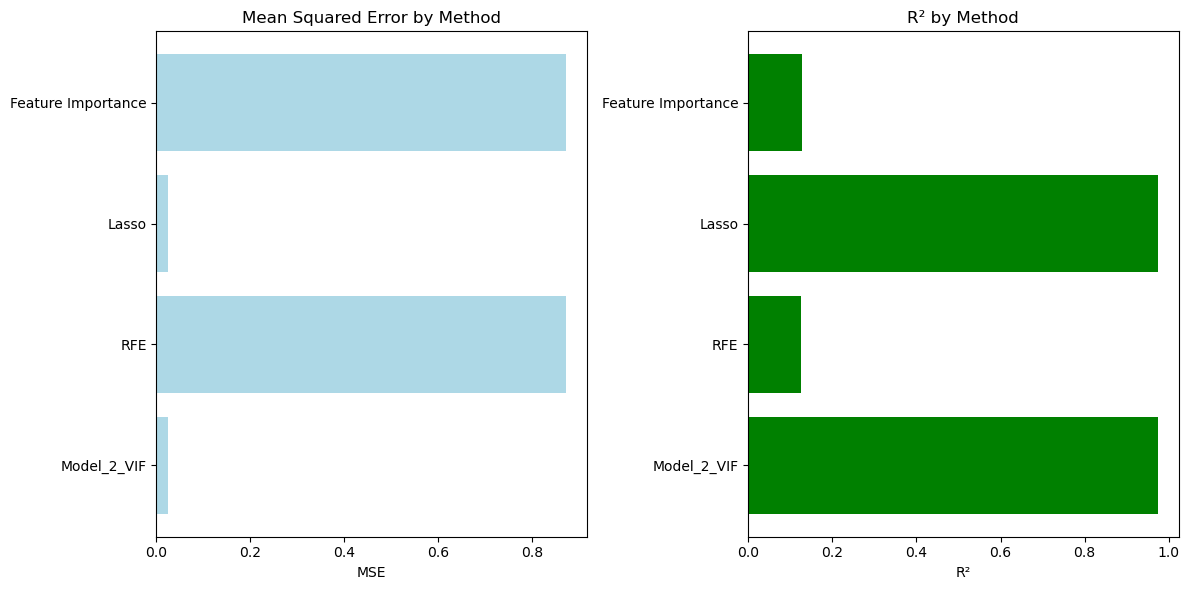

In [62]:

methods = list(results.keys())
mse_values = [results[method][0] for method in methods]
r2_values = [results[method][1] for method in methods]

# Plotting MSE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(methods, mse_values, color='lightblue')
plt.xlabel('MSE')
plt.title('Mean Squared Error by Method')

# Plotting R²
plt.subplot(1, 2, 2)
plt.barh(methods, r2_values, color='green')
plt.xlabel('R²')
plt.title('R² by Method')

plt.tight_layout()
plt.show()


### DIAGNOSTIC PLOTS

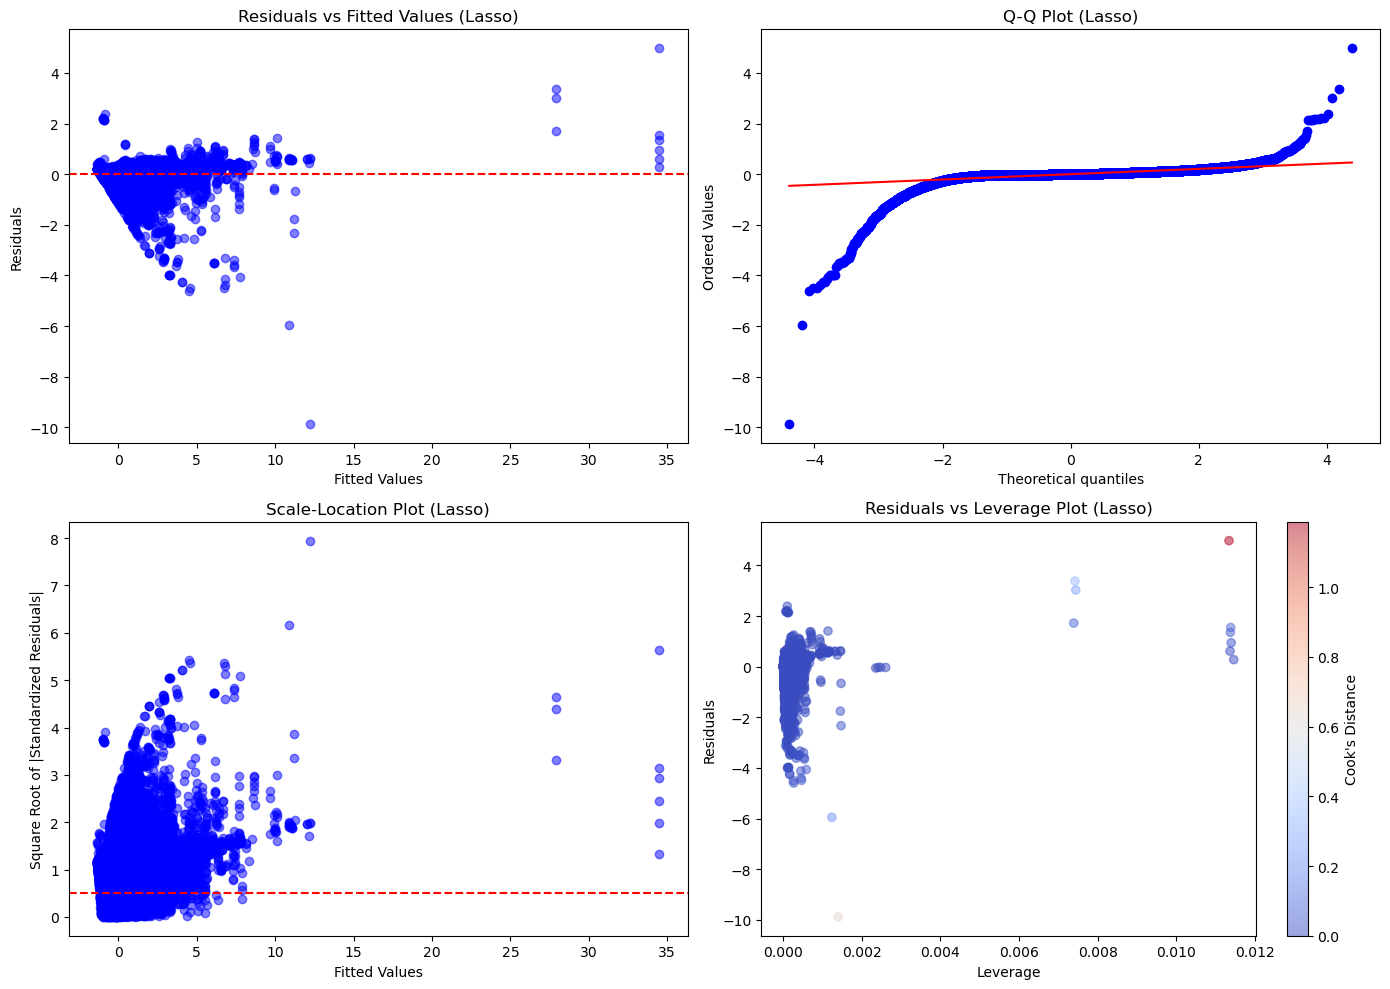

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have already split your data into X_train_sm, X_test_sm, y_train, and y_test

# Fit the Lasso model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_sm[['loan_age', 'time_to_maturity', 'FICO_orig_time', 'balance_orig_time']], y_train)

# Predict on test data
y_pred = lasso.predict(X_test[['loan_age', 'time_to_maturity', 'FICO_orig_time', 'balance_orig_time']])

# Calculate residuals
residuals = y_test - y_pred

# Prepare the subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs. Fitted Values Plot
axs[0, 0].scatter(y_pred, residuals, color='blue', alpha=0.5)
axs[0, 0].axhline(0, color='red', linestyle='--')
axs[0, 0].set_xlabel('Fitted Values')
axs[0, 0].set_ylabel('Residuals')
axs[0, 0].set_title('Residuals vs Fitted Values (Lasso)')

# 2. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axs[0, 1])
axs[0, 1].set_title('Q-Q Plot (Lasso)')

# 3. Scale-Location Plot
standardized_residuals = residuals / np.std(residuals)
sqrt_abs_residuals = np.sqrt(np.abs(standardized_residuals))
axs[1, 0].scatter(y_pred, sqrt_abs_residuals, color='blue', alpha=0.5)
axs[1, 0].axhline(y=np.mean(sqrt_abs_residuals), color='red', linestyle='--')
axs[1, 0].set_xlabel('Fitted Values')
axs[1, 0].set_ylabel('Square Root of |Standardized Residuals|')
axs[1, 0].set_title('Scale-Location Plot (Lasso)')

# 4. Residuals vs. Leverage Plot
X_test_sm_with_const = sm.add_constant(X_test)
model = sm.OLS(y_test, X_test_sm_with_const).fit()
influence = model.get_influence()
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]
scatter = axs[1, 1].scatter(leverage, residuals, c=cooks_d, cmap='coolwarm', alpha=0.5)
axs[1, 1].set_xlabel('Leverage')
axs[1, 1].set_ylabel('Residuals')
axs[1, 1].set_title('Residuals vs Leverage Plot (Lasso)')
fig.colorbar(scatter, ax=axs[1, 1], label='Cook\'s Distance')

# Adjust layout
plt.tight_layout()
plt.show()


##### Cross Validation

In [64]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

In [65]:
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2


In [72]:
lasso = Lasso(alpha=0.1)


kf = KFold(n_splits=5, shuffle=True, random_state=42)


mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

# Convert to numpy arrays for easy manipulation
mse_scores = np.array(mse_scores)
r2_scores = np.array(r2_scores)

# Print results
print(f"Mean MSE: {mse_scores.mean():.4f} ± {mse_scores.std():.4f}")
print(f"Mean R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")



Mean MSE: 0.0256 ± 0.0013
Mean R²: 0.9744 ± 0.0014


These cross-validation results suggest that the Lasso model is performing very well

#### Hyperparameter Tuning with GridSearchCV

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': np.logspace(-4, 4, 50)  # Search for alpha values in the range from 0.0001 to 10000
}


In [70]:
# Define the Lasso model
lasso = Lasso()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Alpha: {best_params['alpha']}")
print(f"Best Score (Negative MSE): {best_score:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Alpha: 0.0001
Best Score (Negative MSE): -0.0261


### Using the best alpha for the Lasso Model

In [73]:
lasso = Lasso(alpha=0.0001)


kf = KFold(n_splits=5, shuffle=True, random_state=42)


mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

# Convert to numpy arrays for easy manipulation
mse_scores = np.array(mse_scores)
r2_scores = np.array(r2_scores)

# Print results
print(f"Mean MSE: {mse_scores.mean():.4f} ± {mse_scores.std():.4f}")
print(f"Mean R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

Mean MSE: 0.0254 ± 0.0013
Mean R²: 0.9746 ± 0.0014


## OPTIMAL REGRESSION MODEL

In [81]:
#best_alpha = best_params['alpha']

final_lasso = Lasso(alpha=0.1)
final_lasso.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = final_lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final Model Alpha: {best_alpha}")
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")


Final Model Alpha: 0.0001
Test MSE: 0.0243
Test R²: 0.9754


In [82]:
# Get coefficients
coefficients = pd.Series(final_lasso.coef_, index=X_train.columns).sort_values(ascending=False)
print(coefficients)

time_to_maturity       0.002449
balance_orig_time      0.000004
interest_rate_time     0.000000
gdp_time              -0.000000
status_time           -0.000000
REtype_SF_orig_time   -0.000000
FICO_orig_time        -0.000057
loan_age              -0.000725
dtype: float64


In [79]:
# Get selected features
selected_features = X_train.columns[final_lasso.coef_ != 0].tolist()
print(f"Selected Features: {selected_features}")


Selected Features: ['loan_age', 'time_to_maturity', 'interest_rate_time', 'gdp_time', 'FICO_orig_time', 'status_time', 'balance_orig_time', 'REtype_SF_orig_time']
